# Learning linear conservative system using a symplectic neural network


## Introduction

In this notebook we will use a structure-preserving neural network to learn a function $\phi_t:\mathbb{R}^{2n}\rightarrow\mathbb{R}^{2n}$ from a data set.

We know that the unknown function $\phi_t(x(0))=x(t)$ is the solution of linear conservative ordinary differential equation (ODE) $$\dot{x}(t) = Ax(t),$$ where $A$ is a Hamiltonian matrix. That is, it is of the form $A=JM$, where $J=-J^T$ is a skew-symmetric, symplectic matrix and $M=M^T$ is a symmetric matrix. 

The data therefore has the property of being generated by a symplectic transformation, meaning that the map $\phi_t$ satisfies the following relationship 
$$\frac{\partial\phi_t(x)}{\partial x}J\frac{\partial\phi_t(x)}{\partial x}^T=J$$

We will exploit this knowledge by learning the map using a symplectic neural network (SympNet). A SympNet is a neural network, which we will denote by $\mathcal{N}:\mathbb{R}^{2n}\rightarrow\mathbb{R}^{2n}$ that, by construction satifies the above symplectic condition, that is: 
$$\frac{\partial\mathcal{N}(x)}{\partial x}J\frac{\partial\mathcal{N}(x)}{\partial x}^T=J.$$

The advantage of doing so means that the hypothesis space of the neural network $\mathcal{N}$ is significantly smaller than that of a generic (non-structure-preserving) neural network, allowing us to learn frmo high dimensional data much more efficiently. 

## Task

In this notebook, we will generate some data from a linear symplectic transformation (i.e., an ordinary differential equation with a quadratic Hamiltonian) then learn its dynamics with a SympNet. 

You are free to change the variables in capital letters as you like. 

In [1]:
import torch

torch.set_default_dtype(torch.float64)
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Generate data 

We will generate data of the form $\{x_i, \phi(x_i)\}_{i=1}^m$, where the $x_i\in\mathbb{R}^{2n}$ are generated randomly in the hypercube $[-1, 1]^{2n}$. The dimension of the data is $2n$ (it has to be even), where `DIM = n` is a parameter you can change in the code below. 

The function `generate_linear_hamiltonian_data` returns two tensors `x0` and `x1`, where `x1` is the map $\phi$ applied to `x0`. 

Feel free to increase the dimension of the data `DIM` set or the number of data points in the set `NDATA`. 



In [2]:
from utils import generate_linear_hamiltonian_data

DIM = 32
TIMESTEP = torch.tensor([0.05])
NDATA = 100

x0, x1 = generate_linear_hamiltonian_data(
    dim=DIM, 
    ndata=NDATA, 
    timestep=TIMESTEP,
    device=device,
)

### Initialize the Hamiltonian neural network (P-SympNet) using the `strupnet` package

The Hamiltonian Neural Network we will use is called a P-SympNet. It is a k-layer deep neural network of the following form

$$\mathcal{N}(x) = \mathcal{N}^{[k]}\circ\dots\circ\mathcal{N}^{[1]}(x)$$

where $\phi^{[i]}$ is the $i$'th layer of the network. SympNets differ from standard deep neural networks in that each layer is a symplectic transformation. That is 

$$\frac{\partial\mathcal{N}^{[i]}(x)}{\partial x}J\frac{\partial\mathcal{N}^{[i]}(x)}{\partial x}^T=J,$$
for all $i=1,...,k$.

The advantage of structuring our neural network like this is at least two-fold: 
- (1) Symplectic transformations are defined by a single scalar function, the Hamiltonian $H:\mathbb{R}^{2n}\rightarrow\mathbb{R}$, as opposed to the non-symplectic case, where a map standard deep neural network would have to learn all $2n$ components of the map individually. This means the number of parameters that are needed to learn $\phi$ are significantly reduced by imposing this structure. 
- (2) Symplectic neural networks do not suffer from vanishing gradients, meaning that you can take them arbitrarily deep and the gradients of the $i$ layer is bounded from below by $1$. 




In [3]:
from strupnet import SympNet

sympnet = SympNet(
    dim=DIM,
    max_degree=2,
    layers=2*DIM,
    method='P',
)

## Train the Hamiltonian neural network using the Adams optimiser

Given the data set of the form $\{x_i, \phi(x_i)\}_{i=1}^m$, we will train our P-SympNet $\mathcal{N}$ on a mean squared error loss term 

$$loss = \sum_{i=1}^m \| \mathcal{N}(x_i)-\phi(x_i)\|^2_2.$$

Moreover, for the specific P-SympNets that we are using, we have a universal approximation property, meaning that there exists a P-SympNet, such that for any symplectic transformation $\phi(x)$, there exists a P-SympNet such that 

$$\|\mathcal{N}(x)-\phi(x)\|<\epsilon,$$
for any $\epsilon>0$ and $x$ in some compact subset of $\mathbb{R}^{2n}$. 

Furthermore, P-SympNets have the remarkable property that they can *exactly* represent a *linear* symplectic transformation:
$$\mathcal{N}(x)=\phi(x),$$
where $\phi(x)=Mx$, for $M^TJM=J$ symplectic. As the data set is generated by a linear symplectic transformation, this means that, in theory, we should be able to train our P-SympNet to acheive a loss of machine precision!

Note that this depends on whether or not we have generated enough data for the P-SympNet to learn from. If you find that the loss is not going to a small enough value, you can try adjusting the below parameters in the training algorithm, or increasing the number of data points in the training set. 

The function `train` is a very basic algorithm and will return the model with the lowest training loss. 

/Users/bentapley/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 1000/1000 [00:09<00:00, 107.27it/s, train_loss=2.6e-9, best_train_loss=2.58e-13] 


Final loss value:  2.6033593126980994e-09


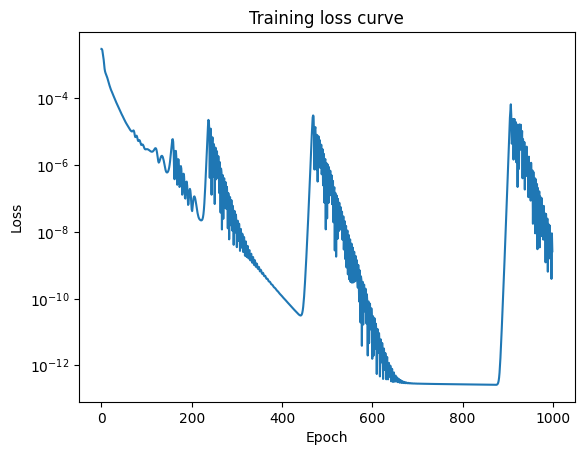

In [4]:
from utils import train
import matplotlib.pyplot as plt

NEPOCHS = 1000
LEARNING_RATE = 0.05
WEIGHT_DECAY = 0.0

training_curve = train(
    net=sympnet,
    x0=x0,
    x1=x1,
    lr=LEARNING_RATE,
    nepochs=NEPOCHS,
    timestep=TIMESTEP,
    tol=1e-14,
    weight_decay=WEIGHT_DECAY,
    use_best_train_loss=True, 
)

plt.semilogy(training_curve)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss curve')
plt.show()


## Compare the prediction with the true solution

Now we will generate a set of initial conditions `p0` and `q0`, and compute the solution from this starting point over `NSTEPS` iterations of the true map $\phi$. We will compare this against `NSTEPS` iterations of the learned P-SympNet $\mathcal{N}$. 

The following code also generates a GIF to visualise the evolution of the two solutions. 

In [5]:
from utils import create_gif, generate_linear_hamiltonian_trajectory

NSTEPS = 1000

# Initial conditions
z = torch.linspace(-1, 1, DIM)
p0, q0 = torch.zeros(DIM), torch.exp(-z**2*100)

# True solution
true_sol = generate_linear_hamiltonian_trajectory(p0, q0, TIMESTEP, NSTEPS)

# Predicted solution
pred_sol = torch.zeros(NSTEPS + 1, 2*DIM)
pred_sol[0, :] = true_sol[0, :]
for i in range(NSTEPS):
    pred_sol[i+1, :] = sympnet(x=pred_sol[i, :], dt=TIMESTEP).detach()

create_gif(pred_sol[:, DIM:], exact_solution=true_sol[:, DIM:], title='linear_system', duration=0.01)
